# Computing Mean of a Likelihood Ratio Process

```{contents} Contents
:depth: 2
```

## Overview

In  {doc}`this lecture <likelihood_ratio_process>` we described a peculiar property of a likelihood ratio process, namely, that it's mean equals one for all $t \geq 0$ despite it's converging to zero almost surely.

While it is easy to verify that peculiar properly analytically (i.e., in population), it is challenging to use a computer simulation to verify it via an application of a law of large numbers that entails studying sample averages of repeated simulations.  

To confront this challenge, this lecture puts __importance sampling__ to work to accelerate convergence of sample averages to population means.

We use  importance sampling to estimate the mean of a cumulative likelihood ratio $L\left(\omega^t\right) = \prod_{i=1}^t \ell \left(\omega_i\right)$.

We start by importing some Python packages.

In [1]:
import numpy as np
from numba import njit, vectorize, prange
import matplotlib.pyplot as plt
%matplotlib inline
from math import gamma
from scipy.stats import beta

## Mathematical Expectation of Likelihood Ratio

In {doc}`this lecture <likelihood_ratio_process>`, we studied a likelihood ratio $\ell \left(\omega_t\right)$

$$
\ell \left( \omega_t \right) = \frac{f\left(\omega_t\right)}{g\left(\omega_t\right)}
$$

where $f$ and $g$ are densities for Beta distributions with parameters $F_a$, $F_b$, $G_a$, $G_b$.

Assume that an i.i.d. random variable $\omega_t \in \Omega$ is generated by $g$.

The **cumulative likelihood ratio**  $L \left(\omega^t\right)$ is

$$
L\left(\omega^t\right) = \prod_{i=1}^t \ell \left(\omega_i\right)
$$

Our goal is to approximate the mathematical expectation $E \left[ L\left(\omega^t\right) \right]$ well.

In {doc}`this lecture <likelihood_ratio_process>`, we showed that  $E \left[ L\left(\omega^t\right) \right]$  equals $1$ for all $t$.
We want to check out how well this holds if we replace $E$ by with  sample averages from simulations.

This turns out to be easier said than done because for
Beta distributions assumed above, $L\left(\omega^t\right)$ has
a very skewed distribution with a very long tail as $t \rightarrow \infty$.

This property makes it difficult  efficiently and accurately to estimate the mean by standard Monte Carlo simulation methods.

In this lecture we explore how a standard Monte Carlo method fails and how **importance sampling**
provides a more computationally efficient way to approximate the mean of the cumulative likelihood ratio.

We first take a look at the density functions `f` and `g` .

In [2]:
# Parameters in the two beta distributions.
F_a, F_b = 1, 1
G_a, G_b = 3, 1.2

@vectorize
def p(w, a, b):
    r = gamma(a + b) / (gamma(a) * gamma(b))
    return r * w ** (a-1) * (1 - w) ** (b-1)

# The two density functions.
f = njit(lambda w: p(w, F_a, F_b))
g = njit(lambda w: p(w, G_a, G_b))

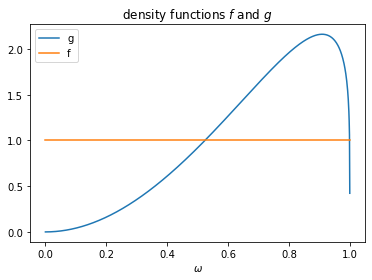

In [3]:
w_range = np.linspace(1e-5, 1-1e-5, 1000)

plt.plot(w_range, g(w_range), label='g')
plt.plot(w_range, f(w_range), label='f')
plt.xlabel('$\omega$')
plt.legend()
plt.title('density functions $f$ and $g$')
plt.show()

The likelihood ratio is `l(w)=f(w)/g(w)`.

In [4]:
l = njit(lambda w: f(w) / g(w))

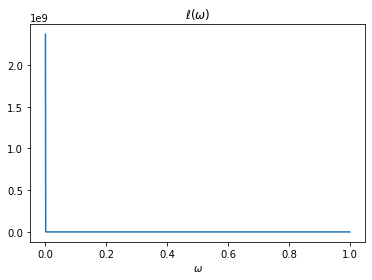

In [5]:
plt.plot(w_range, l(w_range))
plt.title('$\ell(\omega)$')
plt.xlabel('$\omega$')
plt.show()

The above plots shows that as $\omega \rightarrow 0$, $f \left(\omega\right)$ is unchanged and $g \left(\omega\right) \rightarrow 0$, so  the likelihood ratio approaches infinity.

A Monte Carlo approximation of $\hat{E} \left[L\left(\omega^t\right)\right] = \hat{E} \left[\prod_{i=1}^t \ell \left(\omega_i\right)\right]$  would repeatedly draw $\omega$ from $g$, calculate the likelihood ratio $ \ell(\omega) = \frac{f(\omega)}{g(\omega)}$ for each draw, then average these over all draws.

Because $g(\omega) \rightarrow 0$ as $\omega \rightarrow 0$, such a simulation procedure  undersamples a part of the sample space $[0,1]$ that it is important to visit often in order to do a good job of approximating the mathematical expectation of the likelihood ratio $\ell(\omega)$.

We illustrate this numerically below.

## Importance sampling

We circumvent the issue by using a _change of distribution_ called **importance sampling**.

Instead of drawing from $g$ to generate data during the simulation, we use  an alternative
distribution $h$ to generate draws of $\omega$.

The idea is to design $h$ so  that it oversamples the region of $\Omega$ where
$\ell \left(\omega_t\right)$ has large values but  low density under $g$.

After we construct a sample in this way, we must then weight each realization by the likelihood ratio of $g$ and $h$ when we compute the empirical mean
of the likelihood ratio.

By doing this, we properly account for the fact that we are using $h$ and not  $g$ to simulate data.

To illustrate, suppose were interested in ${E}\left[\ell\left(\omega\right)\right]$.

We could simply compute:

$$
\hat{E}^g \left[\ell\left(\omega\right)\right] = \frac{1}{N} \sum_{i=1}^{N} \ell(w_i^g)
$$

where $\omega_i^g$ indicates that  $\omega_i$ is drawn from $g$.

But using our insight from importance sampling, we could instead calculate the object:

$$
\hat{E}^h \left[\ell\left(\omega\right) \frac{g(w)}{h(w)} \right] = \frac{1}{N} \sum_{i=1}^{N} \ell(w_i^h) \frac{g(w_i^h)}{h(w_i^h)}
$$

where $w_i$ is now drawn from importance distribution $h$.

Notice that the above two  are exactly the same population objects:

$$
E^g\left[\ell\left(\omega\right)\right] = \int_\Omega \ell(\omega) g(\omega) d\omega = \int_\Omega \ell(\omega) \frac{g(\omega)}{h(\omega)} h(\omega) d\omega = E^h\left[\ell\left(\omega\right) \frac{g(\omega)}{h(\omega)}\right]
$$

## Selecting a Sampling Distribution

Since we must use an $h$ that has larger mass in parts of the distribution to which  $g$ puts low mass, we use $h=Beta(0.5, 0.5)$ as our importance distribution.

The  plots compare $g$ and $h$.

In [6]:
g_a, g_b = G_a, G_b
h_a, h_b = 0.5, 0.5

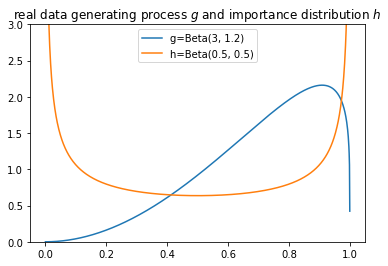

In [7]:
w_range = np.linspace(1e-5, 1-1e-5, 1000)

plt.plot(w_range, g(w_range), label=f'g=Beta({g_a}, {g_b})')
plt.plot(w_range, p(w_range, 0.5, 0.5), label=f'h=Beta({h_a}, {h_b})')
plt.title('real data generating process $g$ and importance distribution $h$')
plt.legend()
plt.ylim([0., 3.])
plt.show()

## Approximating a cumulative likelihood ratio

We now study how to use importance sampling to approximate
${E} \left[L(\omega^t)\right] = \left[\prod_{i=1}^T \ell \left(\omega_i\right)\right]$.

As above, our plan is to draw  sequences $\omega^t$ from $q$ and then re-weight the likelihood ratio appropriately:

$$
\hat{E}^p \left[L\left(\omega^t\right)\right] = \hat{E}^p \left[\prod_{t=1}^T \ell \left(\omega_t\right)\right] = \hat{E}^q \left[\prod_{t=1}^T \ell \left(\omega_t\right) \frac{p\left(\omega_{t}\right)}{q\left(\omega_{t}\right)}\right] =
\frac{1}{N} \sum_{i=1}^{N}\left( \prod_{t=1}^{T} \ell(\omega_{i,t}^h)\frac{p\left(\omega_{i,t}^h\right)}{q\left(\omega_{i,t}^h\right)}\right)
$$

where the last equality uses $\omega_{i,t}^h$ drawn from the importance distribution $q$.

Here $\frac{p\left(\omega_{i,t}^q\right)}{q\left(\omega_{i,t}^q\right)}$ is the weight we assign to each data point $\omega_{i,t}^q$.

Below we prepare a Python function for computing the importance sampling estimates given any beta distributions $p$, $q$.

In [8]:
@njit(parallel=True)
def estimate(p_a, p_b, q_a, q_b, T=1, N=10000):

    μ_L = 0
    for i in prange(N):

        L = 1
        weight = 1
        for t in range(T):
            w = np.random.beta(q_a, q_b)
            l = f(w) / g(w)

            L *= l
            weight *= p(w, p_a, p_b) / p(w, q_a, q_b)

        μ_L += L * weight

    μ_L /= N

    return μ_L

Consider the case when $T=1$, which amounts  to approximating $E_0\left[\ell\left(\omega\right)\right]$

For the standard Monte Carlo estimate, we can set $p=g$ and $q=g$.

In [9]:
estimate(g_a, g_b, g_a, g_b, T=1, N=10000)

0.9598007746164698

For our importance sampling estimate, we set $q = h$.

In [10]:
estimate(g_a, g_b, h_a, h_b, T=1, N=10000)

0.9978315299621651

Evidently, even at T=1, our importance sampling  estimate is closer to $1$ than is the Monte Carlo estimate.

Bigger differences arise when computing expectations over longer sequences, $E_0\left[L\left(\omega^t\right)\right]$.

Setting $T=10$, we find that the  Monte Carlo method severely underestimates the mean while importance sampling
still produces an estimate close to its theoretical value of unity.

In [11]:
estimate(g_a, g_b, g_a, g_b, T=10, N=10000)

0.5549682142415553

In [12]:
estimate(g_a, g_b, h_a, h_b, T=10, N=10000)

1.0277285411484773

## Distribution of  Sample Mean

We next study the bias and efficiency of the Monte Carlo and importance sampling approaches.

The code  below produces distributions of estimates using both Monte Carlo and importance sampling methods.

In [13]:
@njit(parallel=True)
def simulate(p_a, p_b, q_a, q_b, N_simu, T=1):

    μ_L_p = np.empty(N_simu)
    μ_L_q = np.empty(N_simu)

    for i in prange(N_simu):
        μ_L_p[i] = estimate(p_a, p_b, p_a, p_b, T=T)
        μ_L_q[i] = estimate(p_a, p_b, q_a, q_b, T=T)

    return μ_L_p, μ_L_q

Again, we first consider estimating ${E} \left[\ell\left(\omega\right)\right]$ by setting T=1.

We simulate $1000$ times for each method.

In [14]:
N_simu = 1000
μ_L_p, μ_L_q = simulate(g_a, g_b, h_a, h_b, N_simu)

In [15]:
# standard Monte Carlo (mean and std)
np.nanmean(μ_L_p), np.nanvar(μ_L_p)

(0.9977301224904295, 0.007991249955739632)

In [16]:
# importance sampling (mean and std)
np.nanmean(μ_L_q), np.nanvar(μ_L_q)

(0.9999486676826491, 2.3111019136311974e-05)

Although both methods tend to provide a mean estimate of ${E} \left[\ell\left(\omega\right)\right]$ close to $1$, the importance sampling estimates have  smaller variance.

Next, we present distributions of estimates for $\hat{E} \left[L\left(\omega^t\right)\right]$, in cases for $T=1, 5, 10, 20$.

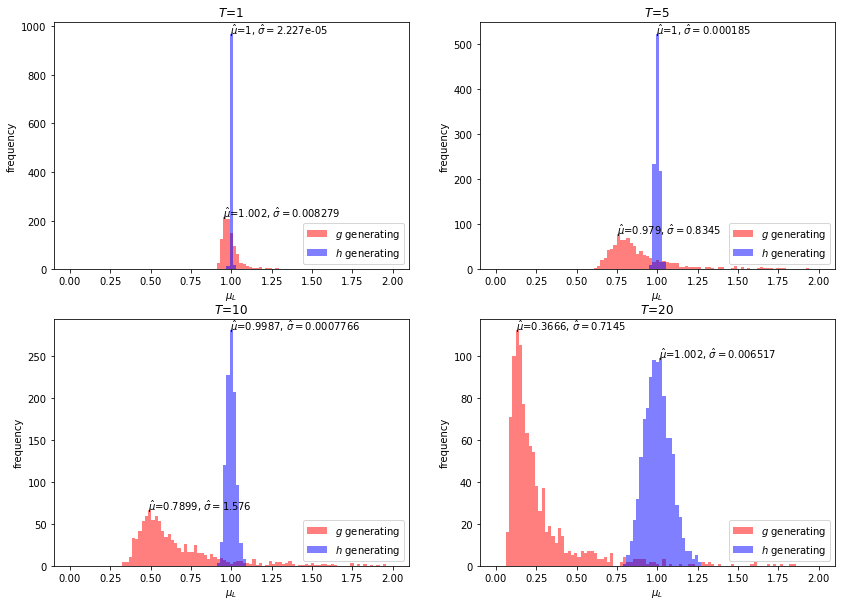

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

μ_range = np.linspace(0, 2, 100)

for i, t in enumerate([1, 5, 10, 20]):
    row = i // 2
    col = i % 2

    μ_L_p, μ_L_q = simulate(g_a, g_b, h_a, h_b, N_simu, T=t)
    μ_hat_p, μ_hat_q = np.nanmean(μ_L_p), np.nanmean(μ_L_q)
    σ_hat_p, σ_hat_q = np.nanvar(μ_L_p), np.nanvar(μ_L_q)

    axs[row, col].set_xlabel('$μ_L$')
    axs[row, col].set_ylabel('frequency')
    axs[row, col].set_title(f'$T$={t}')
    n_p, bins_p, _ = axs[row, col].hist(μ_L_p, bins=μ_range, color='r', alpha=0.5, label='$g$ generating')
    n_q, bins_q, _ = axs[row, col].hist(μ_L_q, bins=μ_range, color='b', alpha=0.5, label='$h$ generating')
    axs[row, col].legend(loc=4)

    for n, bins, μ_hat, σ_hat in [[n_p, bins_p, μ_hat_p, σ_hat_p],
                                  [n_q, bins_q, μ_hat_q, σ_hat_q]]:
        idx = np.argmax(n)
        axs[row, col].text(bins[idx], n[idx], '$\hat{μ}$='+f'{μ_hat:.4g}'+', $\hat{σ}=$'+f'{σ_hat:.4g}')

plt.show()

The simulation exercises above show that the importance sampling estimates are unbiased under all $T$
while the standard Monte Carlo estimates are biased downwards.

Evidently, the bias increases with increases in $T$.

## More Thoughts about Choice of Sampling Distribution

Above, we arbitraily chose $h = Beta(0.5,0.5)$ as the importance distribution.

Is there an optimal importance distribution? 

In our particular case, since we  know in advance that $E_0 \left[ L\left(\omega^t\right) \right] = 1$.

We can use that knowledge to our advantage.

Thus, suppose that we simply use  $h = f$.

When estimating the mean of the likelihood ratio (T=1), we get: 

$$
\hat{E}^f \left[\ell(\omega) \frac{g(\omega)}{f(\omega)} \right] = \hat{E}^f \left[\frac{f(\omega)}{g(\omega)} \frac{g(\omega)}{f(\omega)} \right] = \frac{1}{N} \sum_{i=1}^{N} \ell(w_i^f) \frac{g(w_i^f)}{f(w_i^f)} = 1
$$

In [18]:
μ_L_p, μ_L_q = simulate(g_a, g_b, F_a, F_b, N_simu)

In [19]:
# importance sampling (mean and std)
np.nanmean(μ_L_q), np.nanvar(μ_L_q)

(1.0, 0.0)

We could also use other distributions as our importance distribution.

Below we choose just a few and compare their sampling properties.

In [20]:
a_list = [0.5, 1., 2.]
b_list = [0.5, 1.2, 5.]

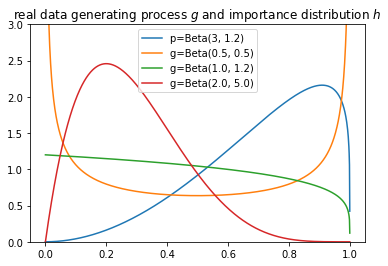

In [21]:
w_range = np.linspace(1e-5, 1-1e-5, 1000)

plt.plot(w_range, g(w_range), label=f'p=Beta({g_a}, {g_b})')
plt.plot(w_range, p(w_range, a_list[0], b_list[0]), label=f'g=Beta({a_list[0]}, {b_list[0]})')
plt.plot(w_range, p(w_range, a_list[1], b_list[1]), label=f'g=Beta({a_list[1]}, {b_list[1]})')
plt.plot(w_range, p(w_range, a_list[2], b_list[2]), label=f'g=Beta({a_list[2]}, {b_list[2]})')
plt.title('real data generating process $g$ and importance distribution $h$')
plt.legend()
plt.ylim([0., 3.])
plt.show()

We consider two additonal distributions.

As a reminder $h_1$ is the original $Beta(0.5,0.5)$ distribution that we used above. 

$h_2$ is the $Beta(1,1.2)$ distribution. 

Note how $h_2$ has a similar shape to $g$ at higher values of distribution but more mass at lower values. 

Our hunch is that $h_2$ should be a good importance sampling distribution.

$h_3$ is the $Beta(2,5)$ distribution. 

Note how $h_3$ has zero mass at values very close to 0 and at values close to 1.

Our hunch is that $h_3$ will  be a poor importance sampling distribution. 


We first simulate a plot the distribution of estimates for $\hat{E} \left[L\left(\omega^t\right)\right]$ using $h_2$ as the importance sampling distribution.

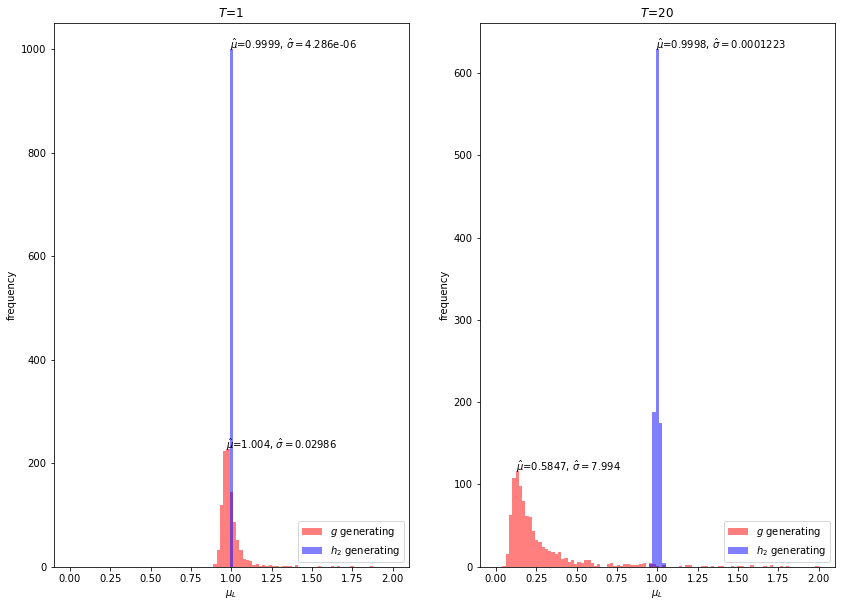

In [22]:
h_a = a_list[1]
h_b = b_list[1]

fig, axs = plt.subplots(1,2, figsize=(14, 10))

μ_range = np.linspace(0, 2, 100)

for i, t in enumerate([1, 20]):


    μ_L_p, μ_L_q = simulate(g_a, g_b, h_a, h_b, N_simu, T=t)
    μ_hat_p, μ_hat_q = np.nanmean(μ_L_p), np.nanmean(μ_L_q)
    σ_hat_p, σ_hat_q = np.nanvar(μ_L_p), np.nanvar(μ_L_q)

    axs[i].set_xlabel('$μ_L$')
    axs[i].set_ylabel('frequency')
    axs[i].set_title(f'$T$={t}')
    n_p, bins_p, _ = axs[i].hist(μ_L_p, bins=μ_range, color='r', alpha=0.5, label='$g$ generating')
    n_q, bins_q, _ = axs[i].hist(μ_L_q, bins=μ_range, color='b', alpha=0.5, label='$h_2$ generating')
    axs[i].legend(loc=4)

    for n, bins, μ_hat, σ_hat in [[n_p, bins_p, μ_hat_p, σ_hat_p],
                                  [n_q, bins_q, μ_hat_q, σ_hat_q]]:
        idx = np.argmax(n)
        axs[i].text(bins[idx], n[idx], '$\hat{μ}$='+f'{μ_hat:.4g}'+', $\hat{σ}=$'+f'{σ_hat:.4g}')

plt.show()

Our simulations suggest that indeed $h_2$ is a quite  good importance sampling distribution for our problem.

Even at $T=20$, the mean  is very close to $1$ and the  variance is small.

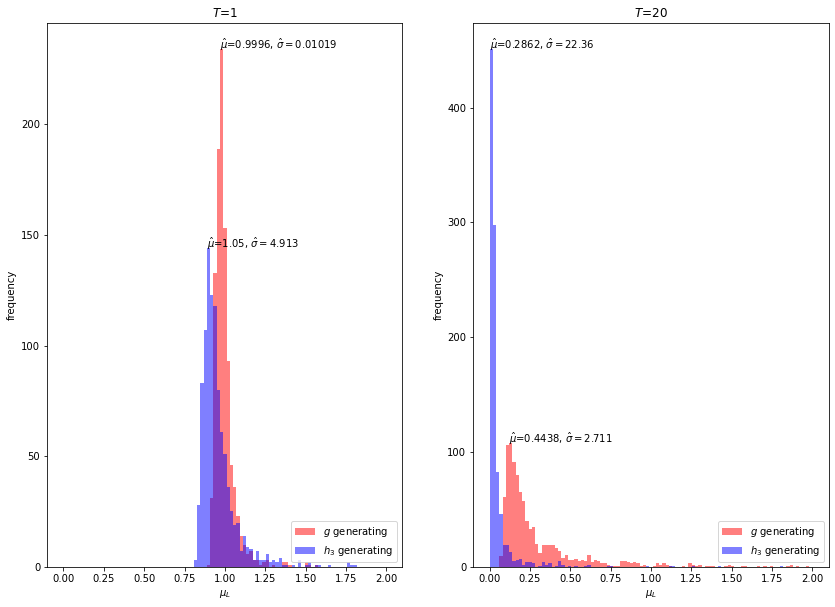

In [23]:
h_a = a_list[2]
h_b = b_list[2]

fig, axs = plt.subplots(1,2, figsize=(14, 10))

μ_range = np.linspace(0, 2, 100)

for i, t in enumerate([1, 20]):


    μ_L_p, μ_L_q = simulate(g_a, g_b, h_a, h_b, N_simu, T=t)
    μ_hat_p, μ_hat_q = np.nanmean(μ_L_p), np.nanmean(μ_L_q)
    σ_hat_p, σ_hat_q = np.nanvar(μ_L_p), np.nanvar(μ_L_q)

    axs[i].set_xlabel('$μ_L$')
    axs[i].set_ylabel('frequency')
    axs[i].set_title(f'$T$={t}')
    n_p, bins_p, _ = axs[i].hist(μ_L_p, bins=μ_range, color='r', alpha=0.5, label='$g$ generating')
    n_q, bins_q, _ = axs[i].hist(μ_L_q, bins=μ_range, color='b', alpha=0.5, label='$h_3$ generating')
    axs[i].legend(loc=4)

    for n, bins, μ_hat, σ_hat in [[n_p, bins_p, μ_hat_p, σ_hat_p],
                                  [n_q, bins_q, μ_hat_q, σ_hat_q]]:
        idx = np.argmax(n)
        axs[i].text(bins[idx], n[idx], '$\hat{μ}$='+f'{μ_hat:.4g}'+', $\hat{σ}=$'+f'{σ_hat:.4g}')

plt.show()

However, $h_3$ is evidently a poor importance sampling distribution forpir problem,
with a mean estimate far away from $1$ for $T = 20$.

Notice that evan at $T = 1$, the mean estimate with importance sampling is more biased than just sampling with  $g$ itself.

Thus, our simulations suggest that we would be better off simply using Monte Carlo
approximations under $g$ than using $h_3$ as an importance sampling distribution for our problem.